In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [67]:
pip install levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.2 MB/s eta 0:00:00


In [68]:
import re
import torch
from unsloth import FastVisionModel
import Levenshtein as Lev

In [73]:
#Functions for computing word error rate and character error rate
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub("<|im_end|>", "", text)
    return text

def compute_wer_arabic(label, prediction):
    # Normalize Arabic text
    label = normalize_arabic(label)
    prediction = normalize_arabic(prediction)

    # Split into words
    label_words = label.split()
    prediction_words = prediction.split()

    # Initialize DP matrix
    n = len(label_words)
    m = len(prediction_words)
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(1, n + 1):
        dp[i][0] = i  # Deletion cost
    for j in range(1, m + 1):
        dp[0][j] = j  # Insertion cost

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if label_words[i - 1] == prediction_words[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]  # No cost for matching words
            else:
                dp[i][j] = min(
                    dp[i - 1][j - 1] + 1,  # Substitution
                    dp[i][j - 1] + 1,      # Insertion
                    dp[i - 1][j] + 1       # Deletion
                )

    # Compute WER
    wer = dp[n][m] / n
    return wer

def compute_cer(label, prediction):

    n = len(label)
    m = len(prediction)
    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(1, n + 1):
        dp[i][0] = i  # Deletion cost
    for j in range(1, m + 1):
        dp[0][j] = j  # Insertion cost


    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if label[i - 1] == prediction[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]  # No cost for matching characters
            else:
                dp[i][j] = min(
                    dp[i - 1][j - 1] + 1,  # Substitution
                    dp[i][j - 1] + 1,      # Insertion
                    dp[i - 1][j] + 1       # Deletion
                )

    cer = dp[n][m] / n
    return cer

def calculate_cer(s1, s2):
    """
    Computes the Character Error Rate, defined as the edit distance.

    Arguments:
        s1 (string): space-separated sentence (actual)
        s2 (string): space-separated sentence (predicted)
    """
    s1 = s1.replace(' ', '')
    s2 = s2.replace(' ', '')
    return Lev.distance(s1, s2)/len(s1)

def calculate_wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2)) / len(s1.split())


def compute_metrics(label, prediction):
    label = normalize_arabic(label)
    prediction = normalize_arabic(prediction)
    wer = calculate_wer(label, prediction)
    cer = calculate_cer(label, prediction)
    return {"wer": wer, "cer": cer}

In [70]:
#Testing the WER AND CER functions
label = "أنا أحب قراءة الكتب العربية كل يوم."
prediction = "أنا أحب قراءة الكتب كل يوم."

print(f"Word error rate: {compute_wer_arabic(label, prediction)}")
print(f"Character error rate: {compute_cer(label, prediction)}")

Word error rate: 0.14285714285714285
Character error rate: 0.22857142857142856


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
checkpoint_path = "/content/drive/MyDrive/Qwin V2 2B checkpoints/checkpoint-853"
model, tokenizer = FastVisionModel.from_pretrained(checkpoint_path,
                                                   load_in_4bit= True)

==((====))==  Unsloth 2024.12.11: Fast Qwen2_Vl vision patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [9]:
###Loading the test dataset
import zipfile

# Specify the path to the zip file
zip_file_path = "/content/drive/MyDrive/OCR/Processed.zip"
extract_to_path = "/content/Augmented_khatt"  # Specify where to extract

# Open and extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Folder unzipped to {extract_to_path}")

Folder unzipped to /content/Augmented_khatt


In [10]:
#Importing required dependencies, and specifying input/output pathes.
import json
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt

test_json_path = "/content/Augmented_khatt/Processed/json_files/test.json"
test_images_folder = "/content/Augmented_khatt/Processed/test_images"


In [11]:
pip install datasets

In [12]:
from datasets import Dataset, DatasetDict, Features, Value, Image
#Function for loading train/test data into a dataset object.
def create_dataset(json_path, images_path):

  examples = []
  with open(json_path, 'r') as f:
    json_list = json.load(f)

  for i in range(0, len(json_list), 1000):
    images_file = os.path.join(images_path, json_list[i]["image_file"])
    images = np.load(images_file)
    print(images_file)
    ctr = 0
    for j in range(i, min(len(images)+i, len(json_list))):
      image = images[ctr]
      label = json_list[j]["text"]
      examples.append({"image": image, "text": label})
      ctr += 1

  print(len(examples))
  img_list = [e["image"] for e in examples]
  text_list = [e["text"] for e in examples]
  print(img_list[0].shape)
  print(type(img_list[0]))
  print(len(img_list))

  features = Features({
      "image": Image(),
      "text": Value("string")
  })

  return Dataset.from_dict({"image": img_list,
                              "text": text_list},
                           features= features)

In [13]:
test_dataset = create_dataset(test_json_path, test_images_folder)

/content/Augmented_khatt/Processed/test_images/test_batch_0.npy
/content/Augmented_khatt/Processed/test_images/test_batch_1.npy
/content/Augmented_khatt/Processed/test_images/test_batch_2.npy
2275
(100, 800)
<class 'numpy.ndarray'>
2275


In [14]:
test_validation_split = test_dataset.train_test_split(test_size= 0.5)
test_dataset = test_validation_split['train']
validation_dataset = test_validation_split['test']

In [15]:
test_dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 1137
})

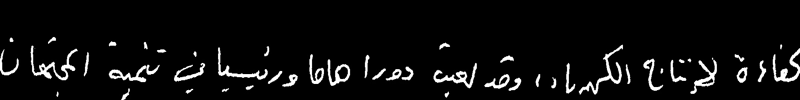

In [30]:
test_dataset[240]["image"]

In [31]:
test_dataset[240]["text"]

'كفاءة لإنتاج الكهرباء ، و قد لعبت دورا هاما و رئيسيا في تنمية المجتمعات'

In [23]:
instruction = "Please analyze the provided image and extract the handwritten text content accurately."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [26]:
converted_dataset_test = [convert_to_conversation(sample) for sample in test_dataset]

In [27]:
converted_dataset_test[2]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Please analyze the provided image and extract the handwritten text content accurately.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=800x100>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'التالية لهذا النص: مشمش، دارق، غيظ، ناء ،  بث ، نسر.'}]}]}

In [42]:
FastVisionModel.for_inference(model) # Enable for inference!

image = test_dataset[240]["image"]
instruction = "Please analyze the provided image and extract the handwritten text content accurately."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
tokens = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

كفاءة الإنتاج الكهربائي ، وقد نجت دورا هاما وربما نجت تقدمه الكثيما  من<|im_end|>


In [47]:
prediction = tokenizer.decode(tokens[0], skip_special_tokens=True).split("\n")[-1]

In [48]:
print(prediction)

كفاءة الإنتاج الكهربائي ، وقد نجت دورا هاما وربما نجت تقدمه الكثيما  من


In [51]:
ground_truth = test_dataset[240]["text"]
print(ground_truth)

كفاءة لإنتاج الكهرباء ، و قد لعبت دورا هاما و رئيسيا في تنمية المجتمعات


In [54]:
metrics = compute_metrics(ground_truth, prediction)
print(f"WER: {metrics['wer']}")
print(f"CER: {metrics['cer']}")

WER: 0.7692307692307693
CER: 0.38028169014084506


In [75]:
def set_metrics(dataset, instruction):
  wer = []
  cer = []
  for sample in dataset:
    image = sample["image"]
    ground_truth = sample["text"]
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
    inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
    ).to("cuda")

    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    tokens = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)
    prediction = tokenizer.decode(tokens[0], skip_special_tokens=True).split("\n")[-1]
    metrics = compute_metrics(ground_truth, prediction)
    wer.append(metrics["wer"])
    cer.append(metrics["cer"])

  avg_wer = sum(wer) / len(wer)
  avg_cer = sum(cer) / len(cer)
  return avg_wer, avg_cer

In [76]:
sample_test = test_dataset.select(range(20))
print(sample_test)
avg_wer, avg_cer = set_metrics(sample_test, instruction)
print(f"Average WER: {avg_wer}")
print(f"Average CER: {avg_cer}")

Dataset({
    features: ['image', 'text'],
    num_rows: 20
})
الذرات ، أما في حالة التوازن العادة فسـس # يتكافح<|im_end|>
عند وصولنا طفنا وسعينا مع # شيخ. كان جاري في الخيمة يتكلم وهو نائم<|im_end|>
التالية لهذا النص: مشمش، دراق، غيظ، ناء ،  بث ، نسر .<|im_end|>
تعلم فائدة الكلمات التالية لهذا النص: مشمش، دراق، غيظ، ناء ،  بث ،<|im_end|>
ذهب نوح مظفر ضرغام بصحبه رؤوف بن لؤي رايق ظافر عطعوط وهلال خازن عفيف<|im_end|>
وذلك مهمه نظوير نوعية التعليم ومستواه في رولهه السبأية . ملاعى تعميقية<|im_end|>
جاري في الخيمة يتكلم وهو نائم  بكلمات لا أفهمها مثل انقض بغـلس له الضابط لزمتك.<|im_end|>
لزمتك. سألت راجح هل بلغ أصحابنا ظ ع ك ، ث خ ض، ب س ش، ص غ هـ<|im_end|>
في هذه الجالية و يكفي لستوى عمل أسماء أي على هيئة أنها ، وكان له<|im_end|>
من و لا يلاحظ المبدأ من القبائل العربية : الماربى في الشمال والاسكناف في الشرق<|im_end|>
ذهب نوح مظفر ضرغام رؤوف بن لؤي رايق ظافر عطعوط وهلال خازن<|im_end|>
طفنا وسعينا مع شيخ. كان جاري في الخيمة يتكلم وهو نائم  بكلمات<|im_end|>
التالية لهذا النص: مشمش، دراق، غيظ